<a href="https://colab.research.google.com/github/katduecker/hh2_dev/blob/main/L5_pyramidal_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [55]:
## Rich et al., 2021; Cerebral Cortex
# uses the same channels as Hay 2011 (standard model of an L5 pyramidal neuron (from rat))
# Rich et al fit a new fast-activating sodium, non-inactivating potassium and Ih channel (everything else is as in Hay et al., 2011)
# activation curves of Na and K shifted to represent more hyperpolarized states
# https://academic.oup.com/cercor/article/31/2/845/5927870

# q10 = 3^((34-21)/10).    (Clamp recordings performed with cell at 21degrees C)


def rich2021(v):

  shift = 7

  # Potassium https://modeldb.science/266984?tab=2&file=HumanCellOrganized_v2/SKv3_1.mod

  nInf =  1/(1+np.exp(((v -(18.700-shift))/(-9.700))))
  nTau =  0.2*20.000/(1+np.exp(((v -(-46.560-shift))/(-44.140))))

  # Sodium https://modeldb.science/266984?tab=2&file=HumanCellOrganized_v2/NaTa_t.mod
  qt = 2.3**((34-21)/10)

  if (v == -38 - shift) or (v == - 66 - shift):
    v += 0.0001

  mAlpha = (0.182 * (v- (-38 - shift)))/(1-(np.exp(-(v- (-38 - shift))/6)))
  mBeta  = (0.124 * (-v+ (-38 - shift)))/(1-(np.exp(-(-v+ (-38 - shift))/6)))
  mTau = (1/(mAlpha + mBeta))/qt
  mInf = mAlpha/(mAlpha + mBeta)

  hAlpha = (-0.015 * (v- (-66 - shift)))/(1-(np.exp((v- (-66 - shift))/6)))
  hBeta  = (-0.015 * (-v+ (-66 - shift)))/(1-(np.exp((-v+ (-66 - shift))/6)))
  hTau = (1/(hAlpha + hBeta))/qt
  hInf = hAlpha/(hAlpha + hBeta)

  return mInf, hInf, nInf, mTau, hTau,  nTau

In [43]:
def vtrap(x, y):
    if abs(x/y) > 1e-6:
        return x / (np.exp(x/y) - 1)
    else:
        return y * (1 - x/y/2)  # Taylor series approximation

In [53]:
def kalmbach2018(v):

    celsius = 34 # according to https://github.com/AllenInstitute/human_neuron_Ih/blob/a5af6f349e1ef269f693aa923a3e698593edb0c7/bmtk/tests/simulator/utils/files/simulator_config.json#L4

    qt = 2.3**((celsius-23)/10)


    # Sodium https://github.com/AllenInstitute/human_neuron_Ih/blob/master/docs/examples/simulator/bionet/components/mechanisms/modfiles/NaTa.mod
    malphaF = 0.182
    mbetaF = 0.124
    mvhalf = -48
    mk = 6

    halphaF = 0.015
    hbetaF = 0.015
    hvhalf = -69
    hk = 6

    mAlpha = malphaF * vtrap(-(v - mvhalf), mk)
    mBeta = mbetaF * vtrap((v - mvhalf), mk)
    mInf = mAlpha/(mAlpha + mBeta)
    mTau = (1/(mAlpha + mBeta))/qt

    hAlpha = halphaF * vtrap(v - hvhalf, hk)
    hBeta = hbetaF * vtrap(-(v - hvhalf), hk)

    hInf = hAlpha/(hAlpha + hBeta)

    hTau = (1/(hAlpha + hBeta))/qt

    # Potassium - they have many different potassium channels, here is KV.31 https://github.com/AllenInstitute/human_neuron_Ih/blob/a5af6f349e1ef269f693aa923a3e698593edb0c7/docs/examples/simulator/bionet/components/mechanisms/modfiles/Kv3_1.mod
    vshift = 0
    nInf =  1/(1+np.exp(((v -(18.700 + vshift))/(-9.700))))
    nTau =  0.2*20.000/(1+np.exp(((v -(-46.560 + vshift))/(-44.140))))

    return mInf, hInf, nInf, mTau, hTau,  nTau

In [109]:
3.0 ** ((36-36)/ 10 )

1.0

In [112]:
# Netpyne S1 https://github.com/suny-downstate-medical-center/S1_Thal_NetPyNE_Frontiers_2022/blob/main/sim/mod/HH2.mod#L88-L91

def netpyne_s1(v):

  celsius = 36 # not super sure
  vtraub  = -63
  tadj = 3.0 ** ((celsius-36)/ 10 ) # Q10 was assumed to be 3 for both currents

  v2 = v - vtraub

  a = 0.32 * (13-v2) / (np.exp((13-v2)/4) - 1)
  a = 0.32 * vtrap(13-v2, 4)
  b = 0.28 * (v2-40) / (np.exp((v2-40)/5) - 1)
  b = 0.28 * vtrap(v2-40, 5)
  mTau = 1 / (a + b) / tadj
  mInf = a / (a + b)

  a = 0.128 * np.exp((17-v2)/18)
  b = 4 / ( 1 + np.exp((40-v2)/5) )
  hTau = 1 / (a + b) / tadj
  hInf = a / (a + b)

  a = 0.032 * (15-v2) / (np.exp((15-v2)/5) - 1)
  a = 0.032 * vtrap(15-v2, 5)
  b = 0.5 * np.exp((10-v2)/40)
  nTau = 1 / (a + b) / tadj
  nInf = a / (a + b)

  return mInf, hInf, nInf, mTau, hTau,  nTau

In [61]:
# HNN

def HNN(v):

  q10 = 3**((37-6.3-30.7)/10)

  alpha = 0.1 * vtrap(-(v+40),10)
  beta = 4 * np.exp(-(v+65)/18)
  sum = alpha + beta
  mTau = 1/(q10*sum)
  mInf = alpha/sum

  alpha = .07 * np.exp(-(v+65)/20)
  beta = 1 / (np.exp(-(v+35)/10) + 1)
  sum = alpha + beta
  hTau = 1/(q10*sum)
  hInf = alpha/sum

  alpha = .01*vtrap(-(v+55),10)
  beta = .125*np.exp(-(v+65)/80)
  sum = alpha + beta
  nTau = 1/(q10*sum)
  nInf = alpha/sum

  return mInf, hInf, nInf, mTau, hTau,  nTau


In [113]:
v_all = np.linspace(-70,50,10000)
mods = [rich2021, kalmbach2018, netpyne_s1, HNN]
model_name = ['Hay 2011/Rich 2021 (L5 pyramidal)', 'Kalmbach 2018 (human L2/3)', 'netpyne S1','HNN']

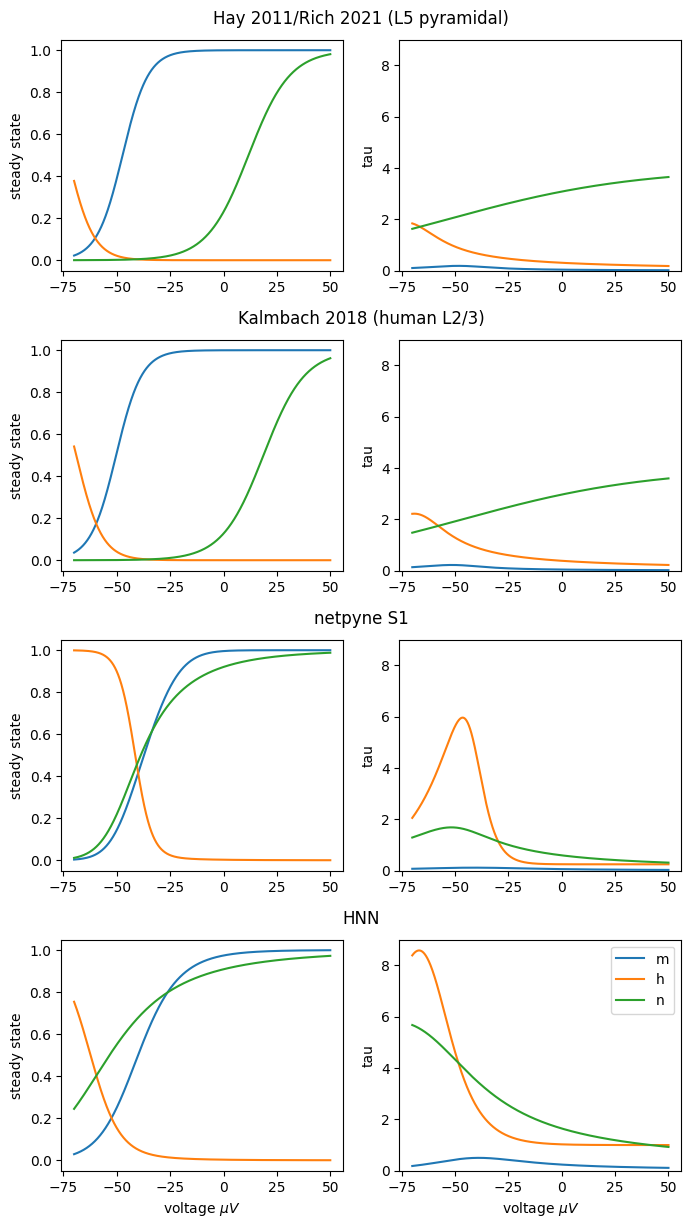

In [114]:
fig, ax = plt.subplots(4,1, figsize=(8,12), sharex=True)

# clear subplots
for a in ax:
    a.remove()

# add subfigure per subplot
gridspec = ax[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for row, subfig in enumerate(subfigs):
  subfig.suptitle(model_name[row])

  acti = np.empty((v_all.shape[0],6))
  for i,v in enumerate(v_all):
    acti[i] = mods[row](v)


  ax = subfig.subplots(nrows=1,ncols=2)
  # activation
  ax[0].plot(v_all,acti[:,0])
  ax[0].plot(v_all,acti[:,1])
  ax[0].plot(v_all,acti[:,2])
  ax[0].set_ylabel('steady state')
  ax[1].plot(v_all,acti[:,3], label='m')
  ax[1].plot(v_all,acti[:,4], label='h')
  ax[1].plot(v_all,acti[:,5], label='n')
  ax[1].set_ylabel('tau')
  ax[1].set_ylim([0, 9])

ax[0].set_xlabel('voltage $\mu V$')
ax[1].set_xlabel('voltage $\mu V$')
ax[1].legend()
#fig.tight_layout()
